Here we attempt to find standing wave solutions to the wave equation $\partial_x^2\psi(x)=-(\frac{\omega}{c})^2\psi(x)$ using Neural Networks. Look at the DSECOP project "[Solving Differential Equations with NNs](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Solving_Differential_Equations_with_NNs/03_solving_differential_equations_neural_networks.ipynb)" for a more thorough introduction if you are unfamiliar.

In [ ]:
# IMPORTS
# Math for the ceiling function
from math import ceil
# Matplotlib for graphing capabilities
from matplotlib import pyplot as plt
import numpy as np
# Modules from the JAX library for creating neural networks
import jax.numpy as jnp
from jax import grad
from jax import random as npr

In [ ]:
def sigmoid(x):
    """
        Calculates the value of the sigmoid function for
        a given input of x
    """
    return 1. / (1. + jnp.exp(-x))

In [ ]:
def neural_network(W, x):
    """
        Inputs:
            W (a list of length 2): the weights of the neural
                network
            x (a float): the input value of the neural network
        Returns:
            Unnamed (a float): The output of the neural network
        Defines a neural network with one hidden layer.  The
        number of neurons in the hidden layer is the length of
        W[0]. The activation function is the sigmoid function
        on the hidden layer an none on the output layer.
    """
    # Calculate the output for the neurons in the hidden layer
    hidden_neuron = sigmoid(jnp.dot(x, W[0]))
    # Calculate the result for the output neuron
    return jnp.dot(hidden_neuron, W[1])

In [ ]:

def psi_analytic(x, omega):
    """
        Inputs:
            x (a 1D NumPy array): the positions
            omega (a float): the frequency of the wave
        Returns:
            psi_exact (a 1D NumPy array): the exact wave function at each position
        Calculates the exact wave function for a standing wave
    """
   # Define the speed of light (m/s)
    c = 3*10**8

    # Set up the initial conditions
    psip_0 = 1
    psi_0 = 0

    #define k
    k=omega/c

    # Define and return the exact solution
    psi_exact = psi_0*np.cos(k*x)+psip_0/(omega/c)*np.sin(k*x)
    return psi_exact

In [ ]:
def psi_trial(xi, nn):
    """
        Inputs:
            xi (a float): the coordinate to calcualte the position at
            nn (a float): the neural network prediction at position xi
        Returns:
            Unnamed (a float): The neural network prediction for the position at
                the given position

    """
    # Define the speed of light (m/s)
    c = 3*10**8

    #We chose the boundary condition that psi is 0 at 0.
    return nn*xi**2+xi

# The derivative of the trial wavefunction
psip_trial = grad(psi_trial)
# The second derivative of the trial wavefunction
psipp_trial = grad(psip_trial)

In [ ]:
def equation(psi,omega):
  """
        Inputs:
            psi (a float): the wavefunction at position x
            omega (a float): the frequency
        Returns:
            Unnamed (a float): the second derivative of the wavefunction at position x
        Calculates and returns the second derivative of the wavefunction at position x
    """
  # Define the speed of light (m/s)
  c = 3*10**8
  return -((omega/c)**2)*psi

In [ ]:
def loss_function(W, x):
    """
        Inputs:
            W (a list): the weights of the neural network
            x (a 1D NumPy array): the positions to calculate the predicted wavefunction
        Returns:
            loss_sum (a float): The total loss over all times
        The loss function for the neural network to solve for position given
        a function for acceleration.
    """
    # Define a variable to hold the total loss
    loss_sum = 0.

    # Loop through each individual time
    for xi in x:
        # Get the output of the neural network with the given set of weights
        nn = neural_network(W, xi)[0][0]

        # The prediction for psi is related to the neural network
        psi_nn = psi_trial(xi, nn)
        # The prediction for the derivative of the prediction for psi
        psip_nn = psip_trial(xi, nn)
        # The prediction for the derivative of the prediction
        # for psi'
        psipp_nn = psipp_trial(xi, nn)

        # Calculate the true second derivative using the prediction for psi
        psipp_true = equation(psi_nn, omega)

        # Find the error in the true value and the neural network
        # prediction
        err_sqr = (psipp_nn - psipp_true)**2

        # Update the loss sum
        loss_sum += err_sqr

    # Return the loss sum
    return loss_sum

In [ ]:
# Define the frequency constant (using microwaves)
omega = 3*10**8


# Define the number of position steps, the final distance, and the position step (all in meters)
nx = 10
xfinal = 1
dx = xfinal/nx

# Define the position array and generate the exact solution and the numerical solution
x = np.linspace(0, xfinal, nx)

# Generate the key random number
key = npr.PRNGKey(0)
# Set the number of neurons in the hidden layer
number_hidden_neurons = 10
# Initialize the weights of the neural network with random numbers
W = [npr.normal(key,(1, number_hidden_neurons)), npr.normal(key,(number_hidden_neurons, 1))]

# Set the learning rate and the number of training iterations for the network
learning_rate = 0.01
num_training_iterations = 150

# Train the neural network for the specified number of iterations
# Update the weights using the learning rates
for i in range(num_training_iterations):
    loss_grad =  grad(loss_function)(W, x)
    W[0] = W[0] - learning_rate * loss_grad[0]
    W[1] = W[1] - learning_rate * loss_grad[1]

Traced<ConcreteArray(7.284552097320557, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(7.284552, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x79687879e990>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x796871f97a60; to 'JaxprTracer' at 0x796871f95260>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = add a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'fn', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7968706ed070>, name_stack=NameStack(stack=(Transform(name=

In [ ]:
# Calculate the exact solution at every t value
psi_exact = psi_analytic(x,omega)

# Use the trained neural network to generate the predicted results for psi at
# every x value
psi_nn = [psi_trial(xi, neural_network(W, xi)[0][0]) for xi in x]

Text(0, 0.5, 'Wave Profile')

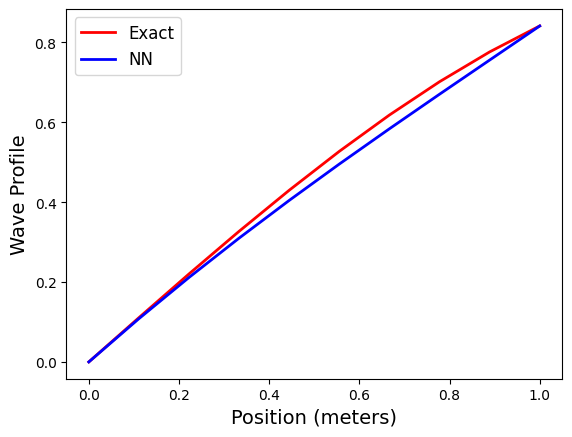

In [ ]:
plt.plot(x, psi_exact,linewidth=2,color="red",label="Exact")
plt.plot(x, psi_nn,linewidth=2,color="blue",label="NN")
plt.legend(fontsize=12)
plt.xlabel("Position (meters)",fontsize=14)
plt.ylabel("Wave Profile",fontsize=14)

Can you improve the network's performance? Try optimizing the hyperparameters.
Try changing the frequency omega, can you get multiple periods?